# Image Inpainting with DCGAN (Deep Convolutional GAN)
From https://ssundar6087.github.io/vision-and-words/python/computer%20vision/deep%20learning/gans/pytorch/2020/05/01/DCGAN-CIFAR10.html

Rather than generate completely new images, we will try to fill-in missing regions of known images. In this sense, we want the known pixels to remain unchanged.

To do this, we will "corrupt" portions of the input images and provide a mask indicating where these corruptions exist. The GAN will then be trained as normal. 

The Generator needs to be modified to take in the corrupted image and a mask.

In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils
import torch.optim as optim
from torchvision import datasets, transforms

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

torch.cuda.is_available()

True

In [43]:
import torchvision.models as models

In [2]:
workers = 0
batch_size = 128
image_size = 32
use_cuda = False
nc = 3
nz = 1
ngf = 64
ndf = 64*2
num_epochs = 60
epochs = num_epochs
lr = 0.0002
beta1 = 0.5
ngpu = 0

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [72]:
class Conv2DModule(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, strides, 
                 padding, bias=False, use_batchnorm=False):
        super(Conv2DModule, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.conv = nn.Conv2d(channels_in, 
                               channels_out, 
                               kernel_size, 
                               strides, 
                               padding, 
                               bias=bias)
        self.batchnorm = nn.BatchNorm2d(channels_out)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        
        x = self.conv(x)
        
        if self.use_batchnorm:
            x = self.batchnorm(x)
            
        return self.activation(x)
    
class ConvTranspose2DModule(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, strides, 
                 padding, bias=False, use_batchnorm=False):
        super(ConvTranspose2DModule, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.conv_transpose = nn.ConvTranspose2d(channels_in, 
                                                 channels_out, 
                                                 kernel_size, 
                                                 strides, 
                                                 padding, 
                                                 bias=bias)
        self.batchnorm = nn.BatchNorm2d(channels_out)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        
        x = self.conv_transpose(x)
        
        if self.use_batchnorm:
            x = self.batchnorm(x)
            
        return self.activation(x)
        

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.conv1 = Conv2DModule(nz, ngf*8, 4, 2, 0, use_batchnorm=True)
        self.conv2 = Conv2DModule(ngf*8, ngf*4, 4, 2, 0, use_batchnorm=True)
        self.conv3 = Conv2DModule(ngf*4, ngf*2, 4, 2, 0, use_batchnorm=True)
        
        self.conv_transpose1 = ConvTranspose2DModule(ngf*2, ngf*8, 4, 2, 1, use_batchnorm=True)
        self.conv_transpose2 = ConvTranspose2DModule(ngf*8, ngf*4, 4, 2, 1, use_batchnorm=True)
        self.conv_transpose3 = ConvTranspose2DModule(ngf*4, ngf*2, 4, 2, 1, use_batchnorm=True)
        
        self.conv_transpose4 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        
        self.main = nn.Sequential(self.conv1, 
                                  self.conv2, 
                                  self.conv3, 
                                  self.conv_transpose1,
                                  self.conv_transpose2, 
                                  self.conv_transpose3,
                                  self.conv_transpose4, 
                                  self.tanh)
        
    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
                                  nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(ndf*2),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(ndf*4),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
                                  nn.Sigmoid())
        
    def forward(self, input):
        return self.main(input)

In [73]:
def train(gen, disc, device, dataloader, optimizerG, optimizerD, criterion, epoch, iters):
    gen.train()
    disc.train()
    img_list = []
    fixed_noise = torch.randn(64, nz, 32, 32, device=device)
    
    # Establish convention for real and fake labels
    real_label = 0.9
    fake_label = 0.1
    for i, data in enumerate(dataloader, 0):
        
        # *** Update Discriminator ***
        disc.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D.
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backwards pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 32,32, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        
        # *** Update Generator ***
        gen.zero_grad()
        label.fill_(real_label)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader), 
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Check how the generator is doing by saving G's output on fixed noise.
        if (iters % 500 == 0) or ((epoch == epochs-1)) and (i == len(dataloader)-1):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(fake)
            
        iters += 1

In [74]:
no_cuda = True
seed = manualSeed
log_interval = 10

use_data = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
    
# Set random seeds and deterministic pytorch for reproducibility
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
    
# Load the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
trainset = datasets.CIFAR10(root='./data', train=True,
                                download=True,
                               transform = transform)
    
trainloader = torch.utils.data.DataLoader(trainset, 
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=workers)
    
# Create the generator
netG = Generator(ngpu).to(device)
    
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))
        
# Apply the weights init function to randomly initialize all weights
# to mean=0, stdev=0.2.
#netG.apply(weights_init)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
    
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
        
# Apply the weights init function to randomly initialize all weights
# to mean=0, stdev=0.2.
#netD.apply(weights_init)
    
try:
    netG.load_state_dict(torch.load("netG_CIFAR"))
except Exception as e:
    print(e)
    print("Couldn't load pretrained Generator")
    
try:
    netD.load_state_dict(torch.load("netD_CIFAR"))
except Exception as e:
    print(e)
    print("Couldn't load pretrained Discriminator")
    
# Initialize BCELoss function
criterion = nn.BCELoss()
    
# Set up Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
                               
iters = 0
for epoch in range(1, epochs+1):
    train(netG, netD, device, trainloader, optimizerG, optimizerD, criterion, epoch, iters)
        
    torch.save(netG.state_dict(), "netG_CIFAR")
    torch.save(netD.state_dict(), "netD_CIFAR")
    print("Nets saved!")

Files already downloaded and verified
[1/60][0/391]	Loss_D: 1.3703	Loss_G: 0.6309	D(x): 0.4888	D(G(z)): 0.4262 / 0.5610
[1/60][50/391]	Loss_D: 1.2748	Loss_G: 0.8656	D(x): 0.5343	D(G(z)): 0.4279 / 0.4189
[1/60][100/391]	Loss_D: 1.3268	Loss_G: 0.9049	D(x): 0.5224	D(G(z)): 0.4498 / 0.4027
[1/60][150/391]	Loss_D: 1.3736	Loss_G: 0.7888	D(x): 0.4735	D(G(z)): 0.4230 / 0.4630
[1/60][200/391]	Loss_D: 1.3688	Loss_G: 1.0204	D(x): 0.5702	D(G(z)): 0.5110 / 0.3583
[1/60][250/391]	Loss_D: 1.3180	Loss_G: 1.0916	D(x): 0.6031	D(G(z)): 0.5088 / 0.3219
[1/60][300/391]	Loss_D: 1.2920	Loss_G: 0.9313	D(x): 0.5712	D(G(z)): 0.4764 / 0.3919
[1/60][350/391]	Loss_D: 1.3290	Loss_G: 1.0393	D(x): 0.5749	D(G(z)): 0.4979 / 0.3465
Nets saved!
[2/60][0/391]	Loss_D: 1.3175	Loss_G: 0.9480	D(x): 0.5549	D(G(z)): 0.4550 / 0.3891
[2/60][50/391]	Loss_D: 1.2648	Loss_G: 0.9977	D(x): 0.5624	D(G(z)): 0.4494 / 0.3622
[2/60][100/391]	Loss_D: 1.3395	Loss_G: 1.0395	D(x): 0.5679	D(G(z)): 0.4981 / 0.3463
[2/60][150/391]	Loss_D: 1.3185	L

KeyboardInterrupt: 

### Visualise outputs

In [95]:
device = torch.device("cuda" if use_cuda else "cpu")
n_examples = 10

netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load("netG_CIFAR"))

# Generate batch of latent vectors
noise = torch.randn(n_examples, nz, 32, 32, device=device)
# Generate fake image batch with G
fake = netG(noise).detach().numpy()
fake = np.swapaxes(fake, 1, 3)
fake = 0.5*fake + 0.5

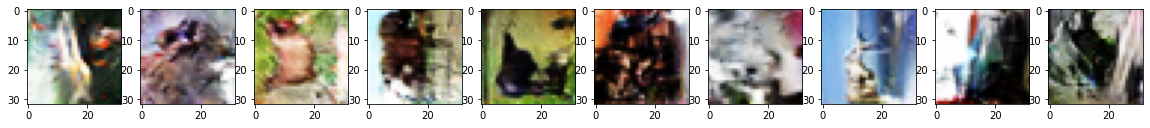

In [96]:
fig, axs = plt.subplots(1, n_examples, figsize=(20,5))

for i in range(n_examples):

    axs[i].imshow(fake[i])
    
plt.show()